<a href="https://colab.research.google.com/github/ErdemAslans/Automated-Pulmonary-Hypertension-Detection-Model-Based-on-ViT/blob/main/T%C3%BCm%C3%B6r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!!pip install  segmentation_models_pytorch
!pip install monai
!pip install timm
!pip install --upgrade albumentations

In [ ]:
import torch
import torchvision
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader,Dataset,Subset
from sklearn.model_selection import train_test_split
from torchvision.models import vit_b_16 # Import the vit_b_16 function
from torchvision.models import ViT_B_16_Weights
import numpy as np
import os
import nibabel as nib
from monai.transforms import (
    Compose, Resize, ToTensor, RandRotate, RandFlip, RandGaussianNoise,
    RandAdjustContrast, NormalizeIntensity, ScaleIntensityRange
)
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import nibabel as nib
from skimage.transform import resize
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install scikit-image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyWavelets

In [ ]:
!pip install bm3d

Eğitim seti boyutu: 1000 dilim
Doğrulama seti boyutu: 333 dilim
Test seti boyutu: 333 dilim


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


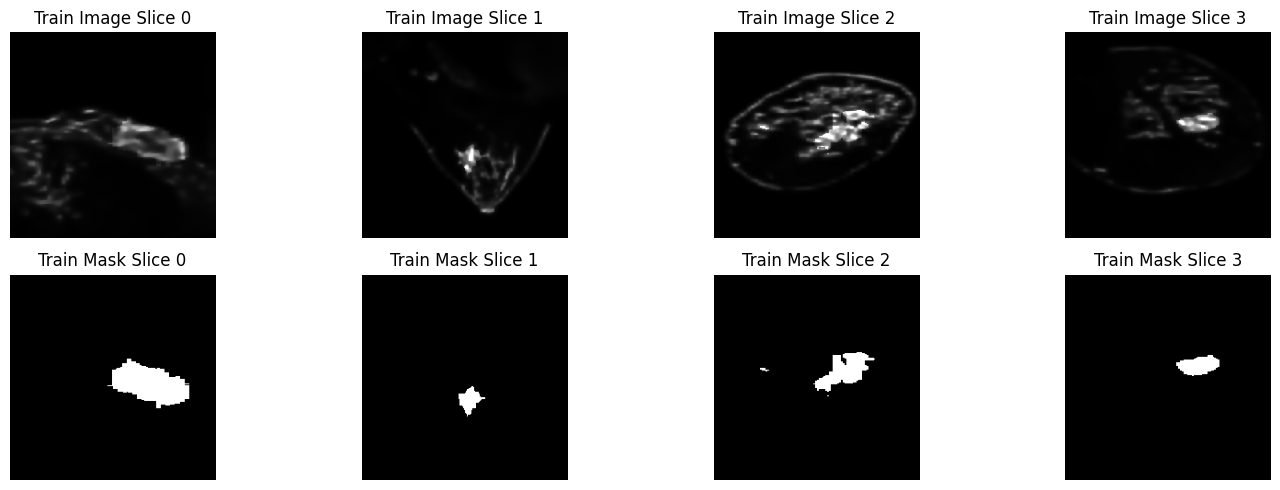

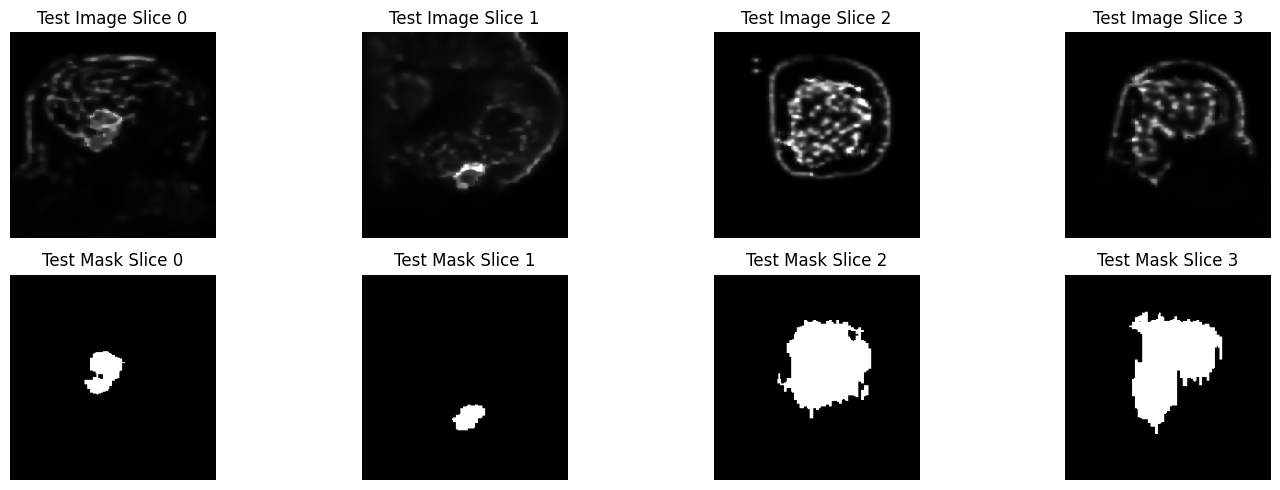

In [ ]:
import os
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, Subset
import nibabel as nib
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import exposure
import cv2
import pywt
from skimage.restoration import denoise_tv_chambolle
# BM3D kütüphanesi eklendi
# Eğer BM3D kütüphanesi yüklü değilse, aşağıdaki satırı yorumlayabilirsiniz
# from bm3d import bm3d

# Albumentations ve diğer gerekli kütüphaneleri import edin
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def enhance_contrast(image, clip_limit=0.6, tile_grid_size=(32,32), gamma=0.3):
    # Görüntüyü 0 ile 1 aralığına normalize et
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val == 0:
        image = np.zeros_like(image)
    else:
        image = (image - min_val) / (max_val - min_val)  # [0, 1] aralığı

    # CLAHE ile kontrastı iyileştir
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    image = clahe.apply((image * 255).astype(np.uint8)) / 255.0

    # Gamma düzeltmesi ile parlaklığı artır
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    image = cv2.LUT((image * 255).astype(np.uint8), table).astype(np.float32) / 255

    # Laplacian filtresi ile kenarları belirginleştirme
    laplacian = cv2.Laplacian(image.astype(np.float64), cv2.CV_64F)
    laplacian = np.clip(laplacian, 0, 1)

    # Laplacian etkisini kontrol etmek için bir ağırlık faktörü ekleyelim
    laplacian_weight = 0.33  # Laplacian ağırlığını artırdım (daha belirgin kenarlar için)

    # Orijinal görüntü ile kenarları birleştir
    enhanced_image = image + laplacian_weight * laplacian
    enhanced_image = np.clip(enhanced_image, 0, 1)

    return enhanced_image

# Non-Local Means (NLM) denoising
def apply_nlm_denoising(image):
    denoised_image = cv2.fastNlMeansDenoising(np.uint8(image * 255), None, h=10, templateWindowSize=7, searchWindowSize=21)
    denoised_image = denoised_image.astype(np.float32) / 255.0
    return denoised_image

# Wavelet Denoising
def apply_wavelet_denoising(image):
    # 2 seviye Haar wavelet dekompozisyonu
    coeffs = pywt.wavedec2(image, 'haar', level=2)

    # Katsayıları soft threshold ile küçültme
    coeffs = list(coeffs)  # coeffs üzerinde işlem yapabilmek için listeye çeviriyoruz
    coeffs[1:] = [tuple(pywt.threshold(c, value=0.1, mode='soft') for c in level) for level in coeffs[1:]]

    # Denoising yapılmış görüntüyü yeniden oluşturma
    denoised_image = pywt.waverec2(coeffs, 'haar')

    # Orijinal görüntü ile aynı boyutta değilse yeniden boyutlandırma
    if denoised_image.shape != image.shape:
        denoised_image = resize(denoised_image, image.shape, mode='reflect', anti_aliasing=True)

    return denoised_image

# Total Variation Denoising
def apply_total_variation_denoising(image):
    denoised_image = denoise_tv_chambolle(image, weight=0.1)
    return denoised_image

# Dice Skoru hesaplama fonksiyonu
def dice_score(mask1, mask2):
    """Dice score hesaplama"""
    # Mask ve görüntü dilimlerinin boyutlarını eşitle
    if mask1.shape != mask2.shape:
        mask2 = resize(mask2, mask1.shape, mode='reflect', anti_aliasing=True)

    intersection = np.sum(mask1[mask2 > 0.5]) * 2.0
    return intersection / (np.sum(mask1) + np.sum(mask2) + 1e-6)

# Görüntü ön işleme fonksiyonu (gerekirse ek işlemler için)
def preprocess_image(image):
    """Görüntüyü daha iyi hale getirmek için geliştirilmiş fonksiyon"""
    # Kontrastı artırma ve normalize etme
    image = exposure.equalize_adapthist(image, clip_limit=0.03)
    # Daha fazla filtreleme işlemi eklenebilir
    return image

# İyi eşleşen dilimleri filtreleme fonksiyonu
def filter_good_matches(image_dir, mask_dir, image_files, mask_files, threshold=0.8):
    good_slices = []
    for img_idx, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_files[img_idx])
        img = nib.load(img_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        for slice_idx in range(min(img.shape[2], mask.shape[2])):  # axial düzlemde dilimleme
            img_slice = img[:, :, slice_idx]
            mask_slice = mask[:, :, slice_idx]

            # Piksel bazlı eşleşme, mask ve img slice'larının normalize edilmesi
            img_slice_norm = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice) + 1e-6)
            mask_slice_norm = (mask_slice - np.min(mask_slice)) / (np.max(mask_slice) - np.min(mask_slice) + 1e-6)

            # Dice skoru veya diğer metriklerle iyi eşleşmeleri kontrol et
            if dice_score(img_slice_norm, mask_slice_norm) > threshold:
                good_slices.append((img_idx, slice_idx))

    return good_slices

# Eğitim Augmentasyonları
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.RandomRotate90(p=0.3),
    ], p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=5, p=0.3),
    A.OneOf([
        A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.1),
    ], p=0.2),
    ToTensorV2(),
])


test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2(),
])


class AugmentedSTVSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, mask_files, target_size=(256, 256),
                 views=['sagittal', 'coronal', 'axial'], mode='train'):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.mask_files = mask_files
        self.target_size = target_size
        self.views = views
        self.mode = mode

        # Pozitif ve negatif dilimleri ayrı ayrı toplayalım
        self.positive_slices, self.negative_slices = self._generate_slices()

        # İyi eşleşen slice'ları filtreleyelim (isteğe bağlı)
        # self.good_slices = filter_good_matches(image_dir, mask_dir, image_files, mask_files, threshold=0.8)

        # Dilimleri dengeleyelim ve over-sampling yapalım
        self.slice_indices = self._balance_slices()

    def calculate_stv_and_quality(self, mask_slice):
        tumor_volume = np.sum(mask_slice > 0.01)  # Mask içindeki tümör hacmi
        quality_score = np.std(mask_slice)  # Maskın varyasyonu (kalite ölçümü)
        return tumor_volume, quality_score

    def _generate_slices(self):
        positive_slices = []
        negative_slices = []
        intensity_threshold = 0.4  # Minimum parlaklık eşiğini artırdık
        stv_threshold = 0.20
        mask_pixel_threshold = 50  # Beyaz piksel sayısı eşik değeri

        # Her bir görüntü ve maske için döngü
        for img_idx, image_file in enumerate(self.image_files):
            img_path = os.path.join(self.image_dir, image_file)
            mask_path = os.path.join(self.mask_dir, self.mask_files[img_idx])
            img = nib.load(img_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()

            # Görüntü ve maske eşleşmesini sağla ve tamamen siyah maskları atla
            for view in self.views:
                if view == 'sagittal':
                    img_slices = img
                    mask_slices = mask
                elif view == 'coronal':
                    img_slices = np.swapaxes(img, 0, 1)
                    mask_slices = np.swapaxes(mask, 0, 1)
                elif view == 'axial':
                    img_slices = np.swapaxes(img, 0, 2)
                    mask_slices = np.swapaxes(mask, 0, 2)

                for slice_idx in range(min(img_slices.shape[0], mask_slices.shape[0])):
                    img_slice = img_slices[slice_idx, :, :]
                    mask_slice = mask_slices[slice_idx, :, :]

                    # Maske diliminde yeterli beyaz piksel olup olmadığını kontrol et
                    white_pixel_count = np.sum(mask_slice > 0.05)

                    # Yetersiz beyaz piksel varsa atla
                    if white_pixel_count < mask_pixel_threshold:
                        continue

                    # Görüntü dilimi üzerinde de bir minimum parlaklık kontrolü
                    if np.mean(img_slice) < intensity_threshold:
                        continue

                    stv_value, quality_score = self.calculate_stv_and_quality(mask_slice)

                    # Pozitif ve negatif dilimleri ayır
                    if stv_value > 0 and quality_score > stv_threshold:
                        positive_slices.append((img_idx, slice_idx, view))
                    else:
                        negative_slices.append((img_idx, slice_idx, view))

        if not positive_slices:
            raise ValueError("Pozitif dilimler bulunamadı, lütfen veri setinizi kontrol edin.")

        return positive_slices, negative_slices

    def _balance_slices(self):
        num_positive = len(self.positive_slices)
        num_negative = len(self.negative_slices)
        # Negatif dilimleri pozitif dilimlerle eşit sayıda olacak şekilde rastgele seçiyoruz
        if num_negative > num_positive:
            negative_slices = random.sample(self.negative_slices, num_positive)
        else:
            negative_slices = self.negative_slices
        # Pozitif dilimleri çoğaltıyoruz (oversampling)
        positive_slices_oversampled = self.positive_slices * 1
        # Dilimleri birleştiriyoruz
        balanced_slices = positive_slices_oversampled + negative_slices
        # Dilimleri karıştırıyoruz
        random.shuffle(balanced_slices)
        return balanced_slices

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        img_idx, slice_idx, view = self.slice_indices[idx]
        img_path = os.path.join(self.image_dir, self.image_files[img_idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[img_idx])
        img = nib.load(img_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        if view == 'sagittal':
            img_slice = img[slice_idx, :, :]
            mask_slice = mask[slice_idx, :, :]
        elif view == 'coronal':
            img_slice = img[:, slice_idx, :]
            mask_slice = mask[:, slice_idx, :]
        elif view == 'axial':
            img_slice = img[:, :, slice_idx]
            mask_slice = mask[:, :, slice_idx]

        # Sabit boyuta getirme
        img_slice = resize(img_slice, self.target_size, mode='reflect', anti_aliasing=True)
        mask_slice = resize(
            mask_slice, self.target_size, mode='reflect', anti_aliasing=False,
            order=0, preserve_range=True
        )

        # Görüntüye ön işlemler uygulama
        img_slice = enhance_contrast(img_slice)
        img_slice = apply_nlm_denoising(img_slice)
        img_slice = apply_wavelet_denoising(img_slice)
        img_slice = apply_total_variation_denoising(img_slice)

        # Maskeyi binarize etme
        mask_slice = (mask_slice > 0.05).astype(np.float32)

        # **Maskeye göre görüntüyü düzenleme**
        highlight_factor = 1.8  # Maskenin olduğu bölgelerde parlaklığı artırma faktörü
        darken_factor = 0.8     # Maskenin olmadığı bölgelerde karartma faktörü

        # Maskenin olduğu bölgeler
        img_slice_masked = img_slice * mask_slice * highlight_factor

        # Maskenin olmadığı bölgeler
        img_slice_non_masked = img_slice * (1 - mask_slice) * darken_factor

        # İki bölgeyi birleştirme
        img_slice = img_slice_masked + img_slice_non_masked

        # Piksel değerlerini 0-1 aralığında sınırlama
        img_slice = np.clip(img_slice, 0, 1)

        # Numpy dizilerini float32 tipine dönüştürme
        img_slice = img_slice.astype(np.float32)

        # Augmentasyonları uygulama
        if self.mode == 'train':
            augmented = train_transforms(image=img_slice, mask=mask_slice)
        else:
            augmented = test_transforms(image=img_slice, mask=mask_slice)

        img_slice = augmented['image']
        mask_slice = augmented['mask']

        # Renk kanallarını çoğaltma (eğer model 3 kanal bekliyorsa)
        if img_slice.shape[0] == 1:
            img_slice = img_slice.repeat(3, 1, 1)

        return img_slice, mask_slice.unsqueeze(0)


    # Görselleştirme fonksiyonu
    def visualize_slice(self, idx):
        img_slice, mask_slice = self.__getitem__(idx)
        img_np = img_slice.permute(1, 2, 0).numpy()
        mask_np = mask_slice.squeeze(0).numpy()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np, cmap='gray')
        plt.title('Görüntü')
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Maske')
        plt.show()

# Eğitim ve test veri setlerini ayırma
image_dir = '/content/drive/MyDrive/Tümör/ISPY1-Tumor-SEG-Radiomics/images_bias-corrected_resampled_zscored_nifti/'
mask_dir = '/content/drive/MyDrive/Tümör/ISPY1-Tumor-SEG-Radiomics/masks_stv_manual/'
views = ['sagittal', 'coronal', 'axial']

# Tüm dosyaları al ve sırala
all_image_files = sorted(os.listdir(image_dir))
all_mask_files = sorted(os.listdir(mask_dir))

# Eğitim ve kalan set olarak ayırın (%70 eğitim, %30 kalan)
train_images, remaining_images, train_masks, remaining_masks = train_test_split(
    all_image_files, all_mask_files, train_size=0.7, random_state=42)

# Kalan seti doğrulama ve test seti olarak ayırın (%15 doğrulama, %15 test)
val_images, test_images, val_masks, test_masks = train_test_split(
    remaining_images, remaining_masks, train_size=0.5, random_state=42)

# Veri setlerini oluşturma
train_dataset_full = AugmentedSTVSegmentationDataset(image_dir, mask_dir,
                                                     train_images, train_masks,
                                                     target_size=(224, 224), views=views, mode='train')
val_dataset_full = AugmentedSTVSegmentationDataset(image_dir, mask_dir,
                                                   val_images, val_masks,
                                                   target_size=(224, 224), views=views, mode='val')
test_dataset_full = AugmentedSTVSegmentationDataset(image_dir, mask_dir,
                                                    test_images, test_masks,
                                                    target_size=(224, 224), views=views, mode='test')

# Subset kullanarak eğitim, doğrulama ve test setlerinin boyutlarını belirleme
test_dataset=Subset( test_dataset_full,list(range(333)))  # 2000 dilim
val_dataset = Subset(val_dataset_full, list(range(333)))  # 400 dilim
train_dataset = Subset(train_dataset_full, list(range(1000)))  # 400 dilim

# DataLoader'ları oluşturma
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Eğitim seti boyutu: {len(train_dataset)} dilim")
print(f"Doğrulama seti boyutu: {len(val_dataset)} dilim")
print(f"Test seti boyutu: {len(test_dataset)} dilim")

# Eğitim ve test verilerini görselleştirme
def visualize_slices(dataloader, title=""):
    imgs, masks = next(iter(dataloader))  # Sadece img ve mask alıyoruz
    num_samples = min(4, imgs.size(0))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Görüntüleri göster
        plt.subplot(2, num_samples, i + 1)
        # Görüntüyü [H, W] şekline getiriyoruz
        image = imgs[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(image, cmap='gray')
        plt.title(f'{title} Image Slice {i}')
        plt.axis('off')

        # Maskeleri göster
        plt.subplot(2, num_samples, i + 1 + num_samples)
        mask = masks[i, 0].cpu().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title(f'{title} Mask Slice {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Eğitim ve test verilerini görselleştirme
visualize_slices(train_dataloader, title="Train")
visualize_slices(test_dataloader, title="Test")


In [ ]:
# Veri yükleyiciden bir örnek al ve boyutları yazdır
images, masks = next(iter(train_dataloader))
print(f"Görüntü boyutları: {images.shape}")  # Beklenen: [Batch Size, Channels, Height, Width]
print(f"Mask boyutları: {masks.shape}")  # Beklenen: [Batch Size, 1, Height, Width]

Görüntü boyutları: torch.Size([32, 3, 224, 224])
Mask boyutları: torch.Size([32, 1, 224, 224])


In [ ]:
# Toplam batch sayısını bulmak için
total_batches = len(train_dataloader)
print(f"Toplam Eğitim Batch Sayısı: {total_batches}")
total_batches = len(val_dataloader)
print(f"Toplam Doğrulama Batch Sayısı: {total_batches}")
total_batches = len(test_dataloader)
print(f"Toplam Batch Sayısı: {total_batches}")

Toplam Eğitim Batch Sayısı: 32
Toplam Doğrulama Batch Sayısı: 11
Toplam Batch Sayısı: 11


In [ ]:
!pip install torchmetrics

In [ ]:
!pip install monai

In [ ]:
!pip install segment_anything

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # ViT için kullanılacak
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import random
import nibabel as nib
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import exposure
import cv2
import pywt
from skimage.restoration import denoise_tv_chambolle
from bm3d import bm3d  # BM3D kütüphanesi eklendi
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.amp import GradScaler, autocast
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CBAM Attention Mekanizması
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAMBlock, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa)
        x = x * sa

        return x

# Multi-Scale Feature Fusion (FPN stili)
class MultiScaleFeatureFusion(nn.Module):
    def __init__(self, embed_dim, num_classes=1, dropout_rate=0.1):
        super(MultiScaleFeatureFusion, self).__init__()
        # Convolution işlemlerinde filtre sayısını azaltıyoruz
        self.conv1 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)

        # Çıkış katmanı
        self.conv_pred = nn.Conv2d(embed_dim // 2, num_classes, kernel_size=1)
        self.dropout = nn.Dropout(p=dropout_rate)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv_pred.weight)

    def forward(self, x):
        # Interpolasyon işlemlerinde ölçek faktörlerini düşürüyoruz
        x1 = F.interpolate(self.conv1(x), size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)  # Küçült
        x2 = self.conv2(x)  # Aynı boyut
        x3 = F.interpolate(self.conv3(x), size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)  # Büyüt

        # Üç farklı boyuttaki özellikleri birleştir
        fused = x1 + x2 + x3

        # Sonuçları dropout ve konvolüyon ile çıkış katmanına ver
        fused = self.dropout(fused)
        output = self.conv_pred(fused)
        return output

# ViT Feature Extractor
class ViTFeatureExtractor(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ViTFeatureExtractor, self).__init__()
        # timm kullanarak önceden eğitilmiş ViT modelini yükle
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, drop_rate=dropout_rate, drop_path_rate=0.2)
        self.vit.head = nn.Identity()  # Sınıflandırıcı katmanı kaldır
        self.embed_dim = self.vit.embed_dim  # Embed dim değerini al

    def forward(self, x):
        B = x.shape[0]
        # ViT modelinden özellikleri al
        x = self.vit.forward_features(x)  # [B, num_patches, embed_dim]
        return x

# SegFormer decoder'ını tanımlayalım ve CBAM ve Multi-Scale Feature Fusion ekleyelim
class SegFormerDecoderWithAttention(nn.Module):
    def __init__(self, embed_dim, num_classes=1, patch_size=16, dropout_rate=0.4):
        super(SegFormerDecoderWithAttention, self).__init__()
        self.patch_size = patch_size
        self.num_patches_side = 224 // self.patch_size
        self.linear_fuse = nn.Linear(embed_dim, embed_dim)
        self.conv_pred = nn.Conv2d(embed_dim, num_classes, kernel_size=1)
        self.dropout = nn.Dropout(p=dropout_rate)

        # CBAM Attention ekliyoruz
        self.cbam = CBAMBlock(embed_dim)
        # Multi-Scale Feature Fusion ekliyoruz
        self.multi_scale_fusion = MultiScaleFeatureFusion(embed_dim, num_classes, dropout_rate)

        # He initialization for better performance
        nn.init.kaiming_normal_(self.linear_fuse.weight)
        nn.init.kaiming_normal_(self.conv_pred.weight)

    def forward(self, x):
        B, N, C = x.shape
        x = x[:, 1:, :]  # CLS token çıkar
        x = self.linear_fuse(x)
        x = x.transpose(1, 2).contiguous().view(B, C, self.num_patches_side, self.num_patches_side)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = self.cbam(x)  # CBAM attention mekanizmasını uyguluyoruz
        x = self.multi_scale_fusion(x)  # Multi-scale feature fusion uyguluyoruz
        return x

# ViT ve SegFormer Modelini birleştiriyoruz
class ViT_SegFormer_Model(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ViT_SegFormer_Model, self).__init__()
        # ViT Feature Extractor
        self.vit = ViTFeatureExtractor(dropout_rate)
        # SegFormer Decoder with CBAM and Multi-Scale Feature Fusion
        self.decoder = SegFormerDecoderWithAttention(embed_dim=self.vit.embed_dim, dropout_rate=dropout_rate)

    def forward(self, x):
        # ViT ile özellik çıkarma
        features = self.vit(x)  # [B, num_patches + 1, embed_dim]
        # SegFormer decoder ile segmentasyon
        output = self.decoder(features)
        return output

# Model tanımı ve eğitimi
model = ViT_SegFormer_Model(dropout_rate=0.2).to(device)

# Tüm parametreleri eğitilebilir yap
for param in model.parameters():
    param.requires_grad = True

# Optimizasyon ve öğrenme oranı planlaması
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/25 - Training: 100%|██████████| 32/32 [01:48<00:00,  3.39s/it]


Epoch 1/25, Training Loss: 0.3852, Recall: 0.7647, F1 Score: 0.6804, Accuracy: 0.9202, IoU: 0.5505, Dice: 0.6804


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:34<00:00,  3.14s/it]


Validation Loss: 0.2797, Recall: 0.9117, F1 Score: 0.7891, Accuracy: 0.9809, IoU: 0.6519, Dice: 0.7891
Yeni en iyi model kaydedildi (Validation Loss: 0.2797)


Epoch 2/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 2/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Epoch 2/25, Training Loss: 0.2247, Recall: 0.8602, F1 Score: 0.8341, Accuracy: 0.9843, IoU: 0.7169, Dice: 0.8341


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.94s/it]


Validation Loss: 0.2498, Recall: 0.7856, F1 Score: 0.8139, Accuracy: 0.9860, IoU: 0.6868, Dice: 0.8139
Yeni en iyi model kaydedildi (Validation Loss: 0.2498)


Epoch 3/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 3/25 - Training: 100%|██████████| 32/32 [01:45<00:00,  3.29s/it]


Epoch 3/25, Training Loss: 0.1841, Recall: 0.8739, F1 Score: 0.8667, Accuracy: 0.9876, IoU: 0.7654, Dice: 0.8667


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.97s/it]


Validation Loss: 0.2217, Recall: 0.8708, F1 Score: 0.8368, Accuracy: 0.9868, IoU: 0.7199, Dice: 0.8368
Yeni en iyi model kaydedildi (Validation Loss: 0.2217)


Epoch 4/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 4/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  2.30s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 4/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


Epoch 4/25, Training Loss: 0.1807, Recall: 0.8779, F1 Score: 0.8692, Accuracy: 0.9878, IoU: 0.7694, Dice: 0.8692


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.95s/it]


Validation Loss: 0.2085, Recall: 0.8771, F1 Score: 0.8474, Accuracy: 0.9878, IoU: 0.7358, Dice: 0.8474
Yeni en iyi model kaydedildi (Validation Loss: 0.2085)


Epoch 5/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 5/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Epoch 5/25, Training Loss: 0.1717, Recall: 0.8824, F1 Score: 0.8764, Accuracy: 0.9887, IoU: 0.7803, Dice: 0.8764


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.93s/it]


Validation Loss: 0.2084, Recall: 0.8722, F1 Score: 0.8475, Accuracy: 0.9878, IoU: 0.7359, Dice: 0.8475
Yeni en iyi model kaydedildi (Validation Loss: 0.2084)


Epoch 6/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 6/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Epoch 6/25, Training Loss: 0.1614, Recall: 0.8909, F1 Score: 0.8843, Accuracy: 0.9892, IoU: 0.7930, Dice: 0.8843


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:33<00:00,  3.02s/it]


Validation Loss: 0.2049, Recall: 0.8407, F1 Score: 0.8503, Accuracy: 0.9885, IoU: 0.7401, Dice: 0.8503
Yeni en iyi model kaydedildi (Validation Loss: 0.2049)


Epoch 7/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 7/25 - Training: 100%|██████████| 32/32 [01:47<00:00,  3.34s/it]


Epoch 7/25, Training Loss: 0.1622, Recall: 0.8944, F1 Score: 0.8837, Accuracy: 0.9890, IoU: 0.7921, Dice: 0.8837


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:33<00:00,  3.00s/it]


Validation Loss: 0.2105, Recall: 0.8557, F1 Score: 0.8458, Accuracy: 0.9879, IoU: 0.7334, Dice: 0.8458


Epoch 8/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 8/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Epoch 8/25, Training Loss: 0.1554, Recall: 0.8971, F1 Score: 0.8889, Accuracy: 0.9895, IoU: 0.8004, Dice: 0.8889


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.99s/it]


Validation Loss: 0.2072, Recall: 0.8503, F1 Score: 0.8484, Accuracy: 0.9882, IoU: 0.7374, Dice: 0.8484


Epoch 9/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 9/25 - Training: 100%|██████████| 32/32 [01:45<00:00,  3.31s/it]


Epoch 9/25, Training Loss: 0.1495, Recall: 0.9015, F1 Score: 0.8935, Accuracy: 0.9901, IoU: 0.8077, Dice: 0.8935


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.98s/it]


Validation Loss: 0.1973, Recall: 0.8896, F1 Score: 0.8564, Accuracy: 0.9884, IoU: 0.7493, Dice: 0.8564
Yeni en iyi model kaydedildi (Validation Loss: 0.1973)


Epoch 10/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 10/25 - Training: 100%|██████████| 32/32 [01:47<00:00,  3.36s/it]


Epoch 10/25, Training Loss: 0.1498, Recall: 0.9019, F1 Score: 0.8932, Accuracy: 0.9900, IoU: 0.8073, Dice: 0.8932


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:33<00:00,  3.00s/it]


Validation Loss: 0.1965, Recall: 0.8579, F1 Score: 0.8570, Accuracy: 0.9889, IoU: 0.7503, Dice: 0.8570
Yeni en iyi model kaydedildi (Validation Loss: 0.1965)


Epoch 11/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 11/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


Epoch 11/25, Training Loss: 0.1444, Recall: 0.9019, F1 Score: 0.8973, Accuracy: 0.9905, IoU: 0.8140, Dice: 0.8973


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


Validation Loss: 0.1955, Recall: 0.8744, F1 Score: 0.8577, Accuracy: 0.9888, IoU: 0.7514, Dice: 0.8577
Yeni en iyi model kaydedildi (Validation Loss: 0.1955)


Epoch 12/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 12/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.34s/it]


Epoch 12/25, Training Loss: 0.1431, Recall: 0.9087, F1 Score: 0.8983, Accuracy: 0.9904, IoU: 0.8156, Dice: 0.8983


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  3.00s/it]


Validation Loss: 0.1914, Recall: 0.8761, F1 Score: 0.8609, Accuracy: 0.9890, IoU: 0.7563, Dice: 0.8609
Yeni en iyi model kaydedildi (Validation Loss: 0.1914)


Epoch 13/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 13/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.34s/it]


Epoch 13/25, Training Loss: 0.1406, Recall: 0.9046, F1 Score: 0.9002, Accuracy: 0.9908, IoU: 0.8188, Dice: 0.9002


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:33<00:00,  3.05s/it]


Validation Loss: 0.1951, Recall: 0.9017, F1 Score: 0.8580, Accuracy: 0.9884, IoU: 0.7519, Dice: 0.8580


Epoch 14/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 14/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  2.28s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 14/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


Epoch 14/25, Training Loss: 0.1411, Recall: 0.9079, F1 Score: 0.8998, Accuracy: 0.9905, IoU: 0.8181, Dice: 0.8998


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.99s/it]


Validation Loss: 0.1911, Recall: 0.8823, F1 Score: 0.8612, Accuracy: 0.9890, IoU: 0.7568, Dice: 0.8612
Yeni en iyi model kaydedildi (Validation Loss: 0.1911)


Epoch 15/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 15/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.34s/it]


Epoch 15/25, Training Loss: 0.1431, Recall: 0.9046, F1 Score: 0.8983, Accuracy: 0.9905, IoU: 0.8157, Dice: 0.8983


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


Validation Loss: 0.1983, Recall: 0.8876, F1 Score: 0.8555, Accuracy: 0.9884, IoU: 0.7480, Dice: 0.8555


Epoch 16/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 16/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.34s/it]


Epoch 16/25, Training Loss: 0.1381, Recall: 0.9104, F1 Score: 0.9021, Accuracy: 0.9908, IoU: 0.8218, Dice: 0.9021


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


Validation Loss: 0.1893, Recall: 0.8760, F1 Score: 0.8627, Accuracy: 0.9892, IoU: 0.7589, Dice: 0.8627
Yeni en iyi model kaydedildi (Validation Loss: 0.1893)


Epoch 17/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 17/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  2.29s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 17/25 - Training: 100%|██████████| 32/32 [01:47<00:00,  3.35s/it]


Epoch 17/25, Training Loss: 0.1351, Recall: 0.9108, F1 Score: 0.9044, Accuracy: 0.9910, IoU: 0.8256, Dice: 0.9044


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:33<00:00,  3.04s/it]


Validation Loss: 0.1892, Recall: 0.8730, F1 Score: 0.8628, Accuracy: 0.9892, IoU: 0.7591, Dice: 0.8628
Yeni en iyi model kaydedildi (Validation Loss: 0.1892)


Epoch 18/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 18/25 - Training: 100%|██████████| 32/32 [01:45<00:00,  3.31s/it]


Epoch 18/25, Training Loss: 0.1344, Recall: 0.9125, F1 Score: 0.9049, Accuracy: 0.9912, IoU: 0.8265, Dice: 0.9049


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.97s/it]


Validation Loss: 0.1883, Recall: 0.8856, F1 Score: 0.8635, Accuracy: 0.9892, IoU: 0.7602, Dice: 0.8635
Yeni en iyi model kaydedildi (Validation Loss: 0.1883)


Epoch 19/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 19/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Epoch 19/25, Training Loss: 0.1336, Recall: 0.9139, F1 Score: 0.9054, Accuracy: 0.9911, IoU: 0.8275, Dice: 0.9054


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


Validation Loss: 0.1896, Recall: 0.8934, F1 Score: 0.8624, Accuracy: 0.9889, IoU: 0.7585, Dice: 0.8624


Epoch 20/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 20/25 - Training: 100%|██████████| 32/32 [01:44<00:00,  3.28s/it]


Epoch 20/25, Training Loss: 0.1330, Recall: 0.9117, F1 Score: 0.9059, Accuracy: 0.9914, IoU: 0.8283, Dice: 0.9059


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


Validation Loss: 0.1873, Recall: 0.8736, F1 Score: 0.8642, Accuracy: 0.9894, IoU: 0.7614, Dice: 0.8642
Yeni en iyi model kaydedildi (Validation Loss: 0.1873)


Epoch 21/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 21/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Epoch 21/25, Training Loss: 0.1335, Recall: 0.9139, F1 Score: 0.9056, Accuracy: 0.9912, IoU: 0.8276, Dice: 0.9056


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.97s/it]


Validation Loss: 0.1879, Recall: 0.8871, F1 Score: 0.8638, Accuracy: 0.9891, IoU: 0.7606, Dice: 0.8638


Epoch 22/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 22/25 - Training: 100%|██████████| 32/32 [01:45<00:00,  3.31s/it]


Epoch 22/25, Training Loss: 0.1361, Recall: 0.9115, F1 Score: 0.9036, Accuracy: 0.9909, IoU: 0.8244, Dice: 0.9036


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.98s/it]


Validation Loss: 0.1886, Recall: 0.9030, F1 Score: 0.8632, Accuracy: 0.9889, IoU: 0.7598, Dice: 0.8632


Epoch 23/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 23/25 - Training: 100%|██████████| 32/32 [01:47<00:00,  3.35s/it]


Epoch 23/25, Training Loss: 0.1353, Recall: 0.9122, F1 Score: 0.9041, Accuracy: 0.9912, IoU: 0.8253, Dice: 0.9041


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  3.00s/it]


Validation Loss: 0.1963, Recall: 0.9240, F1 Score: 0.8571, Accuracy: 0.9880, IoU: 0.7503, Dice: 0.8571


Epoch 24/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 24/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


Epoch 24/25, Training Loss: 0.1359, Recall: 0.9119, F1 Score: 0.9037, Accuracy: 0.9909, IoU: 0.8245, Dice: 0.9037


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:33<00:00,  3.01s/it]


Validation Loss: 0.1892, Recall: 0.8431, F1 Score: 0.8627, Accuracy: 0.9896, IoU: 0.7590, Dice: 0.8627


Epoch 25/25 - Training:   0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 25/25 - Training: 100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


Epoch 25/25, Training Loss: 0.1312, Recall: 0.9153, F1 Score: 0.9073, Accuracy: 0.9913, IoU: 0.8304, Dice: 0.9073


Validating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:32<00:00,  2.99s/it]


Validation Loss: 0.1867, Recall: 0.8526, F1 Score: 0.8646, Accuracy: 0.9897, IoU: 0.7620, Dice: 0.8646
Yeni en iyi model kaydedildi (Validation Loss: 0.1867)


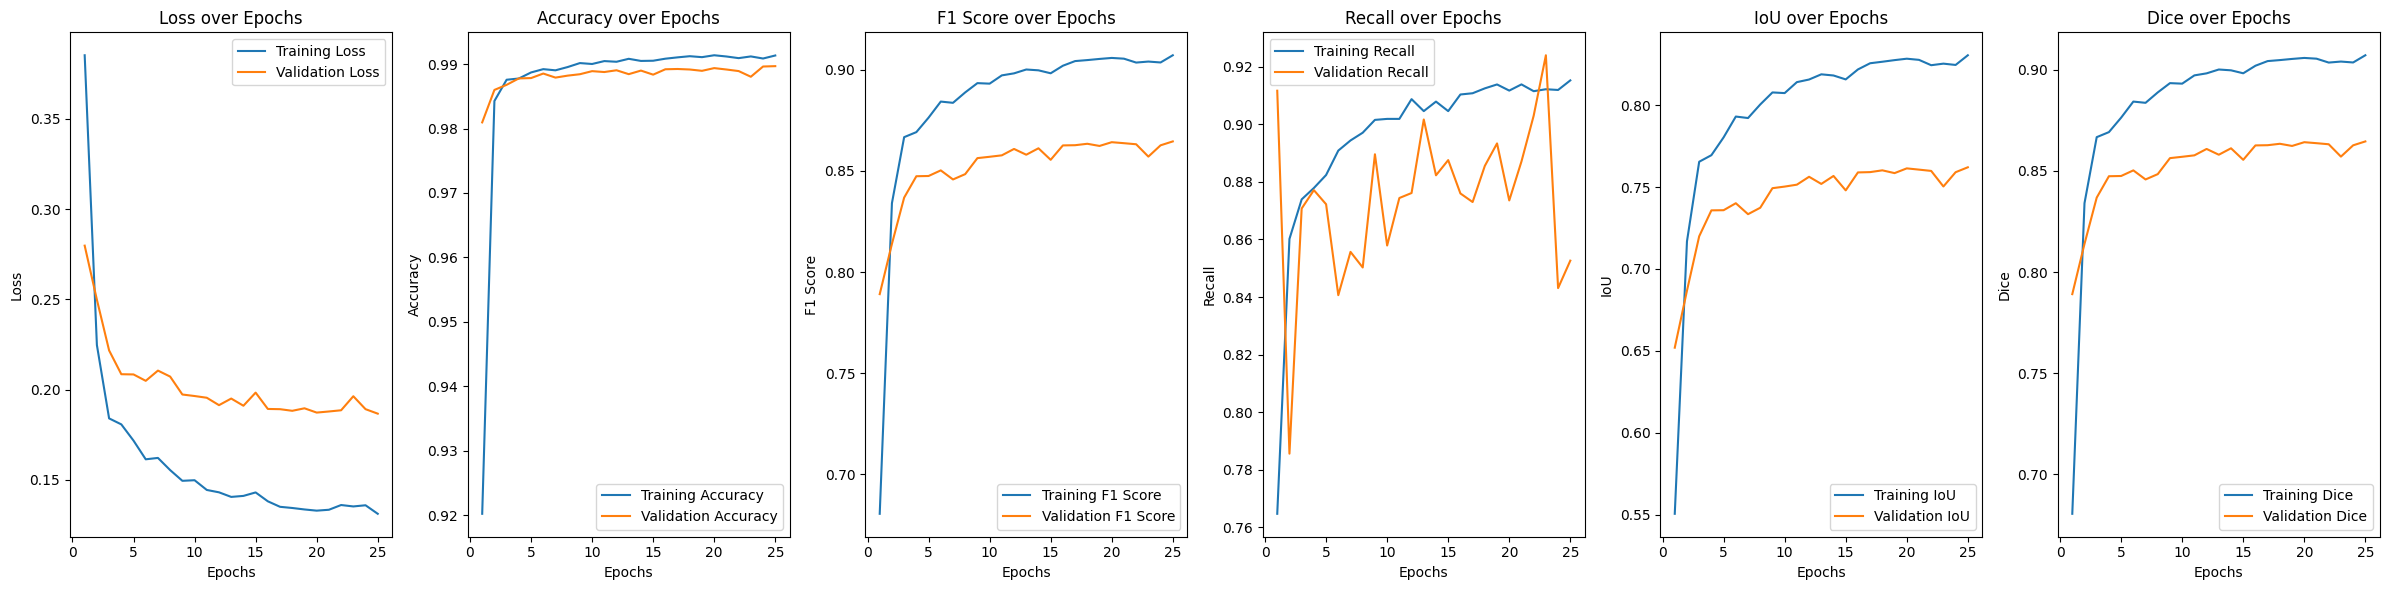

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Dice Score: 0.8138


In [ ]:
  import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

# Kayıp fonksiyonları
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Sigmoid aktivasyon uygulanır
        inputs = torch.sigmoid(inputs)

        # Flatten işlemi
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice katsayısı hesaplama
        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        dice_loss = 1 - dice_coeff

        return dice_loss

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Sigmoid aktivasyon uygulanır
        inputs = torch.sigmoid(inputs)

        # Flatten işlemi
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # IoU hesaplama
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        iou = (intersection + self.smooth) / (union + self.smooth)
        iou_loss = 1 - iou

        return iou_loss

# Kombine kayıp fonksiyonu
class DiceIoULoss(nn.Module):
    def __init__(self, dice_weight=0.5, iou_weight=0.5):
        super(DiceIoULoss, self).__init__()
        self.dice_weight = dice_weight
        self.iou_weight = iou_weight
        self.dice_loss = DiceLoss()
        self.iou_loss = IoULoss()

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        iou = self.iou_loss(inputs, targets)
        loss = self.dice_weight * dice + self.iou_weight * iou
        return loss

# Kayıp fonksiyonunu tanımla
loss_fn = DiceIoULoss(dice_weight=0.5, iou_weight=0.5).to(device)

# Optimizer ve Scheduler
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

# Eğitim ve doğrulama metriklerini takip etmek için listeler
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_recalls, val_recalls = [], []
train_iou_scores, val_iou_scores = [], []
train_dice_scores, val_dice_scores = [], []

def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, num_epochs=30):
    scaler = GradScaler()
    best_val_loss = float('inf')
    patience = 10  # Erken durdurma için sabırlılık değeri
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_f1 = 0.0
        running_accuracy = 0.0
        running_recall = 0.0
        running_iou = 0.0
        running_dice = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            with autocast('cuda'):
                outputs = model(images)
                if outputs.shape != masks.shape:
                    outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

                loss = loss_fn(outputs, masks)
                running_loss += loss.item()

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            # Metrikleri hesapla
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            preds_flat = preds.view(-1).detach().cpu().numpy()
            masks_flat = masks.view(-1).detach().cpu().numpy()

            recall = recall_score(masks_flat, preds_flat, zero_division=0)
            f1 = f1_score(masks_flat, preds_flat, zero_division=0)
            accuracy = accuracy_score(masks_flat, preds_flat)

            intersection = np.logical_and(preds_flat, masks_flat).sum()
            union = np.logical_or(preds_flat, masks_flat).sum()
            iou = (intersection + 1e-6) / (union + 1e-6)
            dice = (2 * intersection + 1e-6) / (preds_flat.sum() + masks_flat.sum() + 1e-6)

            running_recall += recall
            running_f1 += f1
            running_accuracy += accuracy
            running_iou += iou
            running_dice += dice

        avg_loss = running_loss / len(train_loader)
        avg_f1 = running_f1 / len(train_loader)
        avg_accuracy = running_accuracy / len(train_loader)
        avg_recall = running_recall / len(train_loader)
        avg_iou = running_iou / len(train_loader)
        avg_dice = running_dice / len(train_loader)

        train_losses.append(avg_loss)
        train_f1_scores.append(avg_f1)
        train_accuracies.append(avg_accuracy)
        train_recalls.append(avg_recall)
        train_iou_scores.append(avg_iou)
        train_dice_scores.append(avg_dice)

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Recall: {avg_recall:.4f}, "
              f"F1 Score: {avg_f1:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")

        # Doğrulama adımları
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0
        val_accuracy = 0.0
        val_recall = 0.0
        val_iou = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validating"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                if outputs.shape != masks.shape:
                    outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                preds_flat = preds.view(-1).detach().cpu().numpy()
                masks_flat = masks.view(-1).detach().cpu().numpy()

                recall = recall_score(masks_flat, preds_flat, zero_division=0)
                f1 = f1_score(masks_flat, preds_flat, zero_division=0)
                accuracy = accuracy_score(masks_flat, preds_flat)

                intersection = np.logical_and(preds_flat, masks_flat).sum()
                union = np.logical_or(preds_flat, masks_flat).sum()
                iou = (intersection + 1e-6) / (union + 1e-6)
                dice = (2 * intersection + 1e-6) / (preds_flat.sum() + masks_flat.sum() + 1e-6)

                val_recall += recall
                val_f1 += f1
                val_accuracy += accuracy
                val_iou += iou
                val_dice += dice

        avg_val_loss = val_loss / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        val_losses.append(avg_val_loss)
        val_f1_scores.append(avg_val_f1)
        val_accuracies.append(avg_val_accuracy)
        val_recalls.append(avg_val_recall)
        val_iou_scores.append(avg_val_iou)
        val_dice_scores.append(avg_val_dice)

        print(f"Validation Loss: {avg_val_loss:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, "
              f"Accuracy: {avg_val_accuracy:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")

        # Scheduler güncelleme
        scheduler.step(avg_val_loss)

        # En iyi modeli kaydetme ve erken durdurma
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Yeni en iyi model kaydedildi (Validation Loss: {best_val_loss:.4f})")
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Erken durdurma tetiklendi")
                break

# Eğitim sonrası metrikleri görselleştirme
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(24, 6))

    # Kayıp grafiği
    plt.subplot(1, 6, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluk grafiği
    plt.subplot(1, 6, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Skoru grafiği
    plt.subplot(1, 6, 3)
    plt.plot(epochs, train_f1_scores, label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Recall grafiği
    plt.subplot(1, 6, 4)
    plt.plot(epochs, train_recalls, label='Training Recall')
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # IoU grafiği
    plt.subplot(1, 6, 5)
    plt.plot(epochs, train_iou_scores, label='Training IoU')
    plt.plot(epochs, val_iou_scores, label='Validation IoU')
    plt.title('IoU over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Dice grafiği
    plt.subplot(1, 6, 6)
    plt.plot(epochs, train_dice_scores, label='Training Dice')
    plt.plot(epochs, val_dice_scores, label='Validation Dice')
    plt.title('Dice over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Modeli eğitme ve performansı izleme
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, num_epochs=25)

# Eğitim sonrası metrikleri görselleştirme
plot_metrics()

# Test fonksiyonu
def test_model_with_dice(model, test_loader, device):
    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    post_trans = AsDiscrete(threshold=0.5)  # Sigmoid çıktılarını ikili hale getirme

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # Çıktıları 0.5 eşiğinde ikili hale getir
            outputs = post_trans(outputs)

            # Dice skorunu hesapla
            dice_metric(y_pred=outputs, y=masks)

    dice_score = dice_metric.aggregate().item()
    print(f"Test Dice Score: {dice_score:.4f}")
    dice_metric.reset()

# Modeli test etme
test_model_with_dice(model, test_dataloader, device)


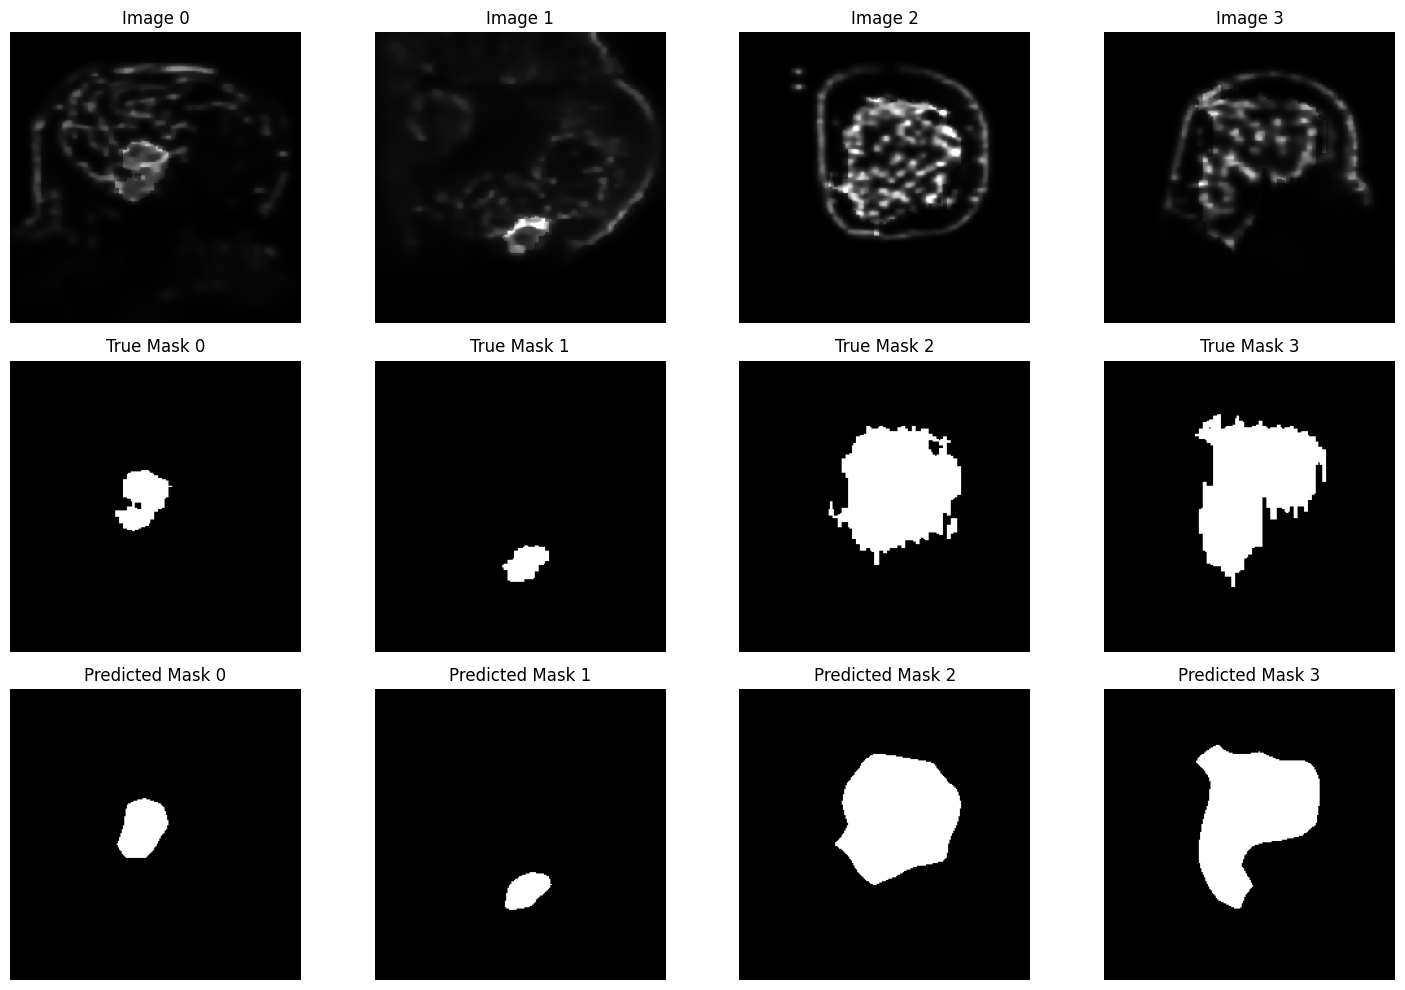

In [ ]:
def visualize_predictions(model, dataloader):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()

    num_samples = min(4, images.size(0))
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        image = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(image, cmap='gray')
        plt.title(f'Image {i}')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        mask = masks[i, 0].cpu().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title(f'True Mask {i}')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        pred = preds[i, 0].cpu().numpy()
        plt.imshow(pred, cmap='gray')
        plt.title(f'Predicted Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Eğitimi tamamladıktan sonra
visualize_predictions(model, test_dataloader)


In [ ]:
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete



def test_model_with_dice(model, test_loader, device):
    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    post_trans = AsDiscrete(threshold=0.5)  # Sigmoid çıktılarını ikili hale getirme

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # Çıktıları 0.5 eşiğinde ikili hale getir
            outputs = post_trans(outputs)

            # Dice skorunu hesapla
            dice_metric(y_pred=outputs, y=masks)

    dice_score = dice_metric.aggregate().item()
    print(f"Test Dice Score: {dice_score:.4f}")
    dice_metric.reset()

# Modeli test etme
test_model_with_dice(model, test_dataloader, device)

Test Dice Score: 0.8138


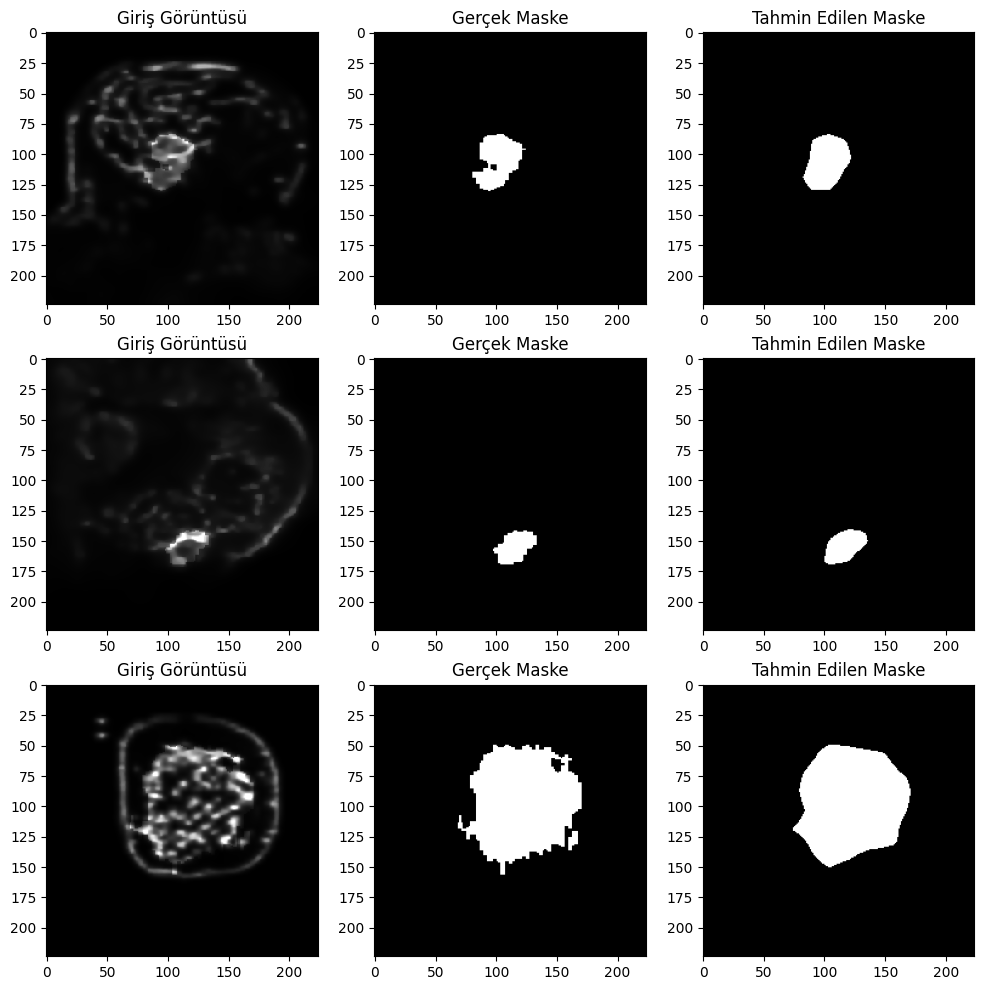

In [ ]:
import matplotlib.pyplot as plt

def visualize_test_results(model, test_loader, device):
    model.eval()

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = outputs > 0.5  # Tahmin edilen maskeleri ikili hale getir

            # Gereksiz boyutu sıkıştır
            outputs = outputs.squeeze(2)

            # İlk batch'ten birkaç örnek görselleştir
            if i == 0:
                fig, axes = plt.subplots(3, 3, figsize=(12, 12))

                for j in range(3):  # İlk 3 görüntü için
                    axes[j, 0].imshow(images[j, 0, :, :].cpu(), cmap='gray')  # Giriş görüntüsü
                    axes[j, 0].set_title('Giriş Görüntüsü')

                    axes[j, 1].imshow(masks[j, 0, :, :].cpu(), cmap='gray')  # Gerçek Maske
                    axes[j, 1].set_title('Gerçek Maske')

                    axes[j, 2].imshow(outputs[j, 0, :, :].cpu(), cmap='gray')  # Tahmin Edilen Maske
                    axes[j, 2].set_title('Tahmin Edilen Maske')

                plt.show()
            break  # Sadece ilk batch'i görselleştir

# Test seti üzerinde görselleştirme
visualize_test_results(model, test_dataloader, device)